# Helper Funcitons

In [1]:
import pandas as pd 

# Function to load a CSV file
def load_csv_file(file_path):
    """Loads a CSV file into a pandas DataFrame and returns it."""
    try:
        df = pd.read_csv(file_path)
        # print(f"Successfully loaded '{file_path}'. Head of the DataFrame:")
        # print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        return None



# Merging data of client, estimations, manual and locations
* before using this notebook please make sure you did use the `Seatfinder_DataCleaning.csv` file before. This provides you with the csv files of the data already filtered by the correct opening hours. 
* This notebook creates 10-minutes slots and then merges the data. It also adds:
    * a column for grouping by building 
    * a column for grouping by hill or valley 
    * removes the covid period and saves it to a seperate data frame

In [2]:
# Load CSV files (already filtered by opening hours)

estimate_df = load_csv_file('data/' + 'estimate_during_opening_hours.csv')
client_df = load_csv_file('data/' + 'wlan_clients_during_opening_hours.csv')
manual_df = load_csv_file('data/' + 'manual_counts_during_opening_hours.csv')
# use the original locaitons.csv file from the sql data set (we already have the opening hours)
locations_df = load_csv_file('exports/'+ 'locations.csv')


In [3]:
estimate_df.head()

print(estimate_df["timestamp"].max())
print(estimate_df["timestamp"].min())

2024-10-15 13:16:32
2016-04-25 10:07:11


In [4]:
client_df.head()

print(client_df["timestamp"].max())
print(client_df["timestamp"].min())

2024-10-15 13:16:32
2016-04-12 13:01:09


In [5]:
manual_df.head()

print(manual_df["timestamp"].max())
print(manual_df["timestamp"].min())

2022-02-23 14:50:57
2016-04-22 13:34:23


In [6]:
locations_df.head()

,id,timestamp,name,longname,url,building,level,room,geocoordinates,availableseats,weeklyopeninghours,wlanaccesspoints,ethernetswitches,superlocation_id
0,19,2016-01-01,UBCUG,"PCB-Bibliothek, UG",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,"Auf der Morgenstelle, Hörsaalzentrum",-1.0,NaN,48.53658;9.03623,54,"C:23:""Leitsystem\\OpeningHours"":1413:{{""base_t...",/^am16-UG-chemBib-2802$/,NaN,NaN
1,12,2016-01-01,UBA6A,"Ammerbau, Ebene 6, Links",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,6.0,NaN,48.52492;9.06310,33,"C:23:""Leitsystem\\OpeningHours"":1753:{{""base_t...",/^br25-6E-links-[0-9]+$/,NaN,NaN
2,20,2016-01-01,UBLZN,Lernzentrum Naturwissenschaften,http://tuebingen.artec-berlin.de/?lang=de_DE&m...,"Auf der Morgenstelle, Gebäude F",2.0,NaN,48.53593;9.03574,101,"C:23:""Leitsystem\\OpeningHours"":159:{{""base_ti...",/^am24-4OG-Biblio2-1131$/,NaN,NaN
3,3,2016-01-01,UBB2HLS,"Historischer Lesesaal, Bonatzbau, EG",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,0.0,NaN,48.52493;9.06116,64,"C:23:""Leitsystem\\OpeningHours"":1413:{{""base_t...",/^wi32-EG-rB018-2-[0-9]+|wi32-EG-rB018-[0-9]+$/,NaN,NaN
4,18,2016-01-01,UBCEG,"PCB-Bibliothek, EG",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,"Auf der Morgenstelle, Hörsaalzentrum",0.0,NaN,48.53658;9.03623,57,"C:23:""Leitsystem\\OpeningHours"":1413:{{""base_t...",/^am16-EG-kl-Arbeitsraum-2802|am16-EG-chemBib2...,NaN,NaN


### removing all unused columns from data

In [7]:
# removing unused columns from locations
locations_df_cleaned = locations_df.drop(["timestamp", "name", "url", "building", "level", "room", "geocoordinates", "wlanaccesspoints", "ethernetswitches", "superlocation_id", "weeklyopeninghours"], axis=1)
locations_df_cleaned.head()

,id,longname,availableseats
0,19,"PCB-Bibliothek, UG",54
1,12,"Ammerbau, Ebene 6, Links",33
2,20,Lernzentrum Naturwissenschaften,101
3,3,"Historischer Lesesaal, Bonatzbau, EG",64
4,18,"PCB-Bibliothek, EG",57


In [8]:
# keep a lookup table with all opening hours for merging later - remove them from all other data frames
hours = estimate_df[["location_id", "Opening", "Closing"]].drop_duplicates("location_id")
hours.head(20)

,location_id,Opening,Closing
0,16,08:00:00,00:00:00
1,15,08:00:00,00:00:00
2,6,08:00:00,00:00:00
3,7,08:00:00,00:00:00
4,8,08:00:00,00:00:00
5,1,08:00:00,00:00:00
6,2,08:00:00,20:00:00
12,9,08:00:00,00:00:00
13,10,08:00:00,00:00:00
16,3,08:00:00,20:00:00


In [9]:
# removing unused columns form estimations 
estimate_df_cleaned = estimate_df.drop(["Closing_adj", "event_time", "Opening", "Closing"], axis=1)
estimate_df_cleaned.head()

,id,location_id,occupiedseats,freeseats,timestamp
0,1,16,16,15,2016-04-25 10:07:11
1,2,15,5,96,2016-04-25 10:07:11
2,3,6,12,30,2016-04-25 10:07:11
3,4,7,13,14,2016-04-25 10:07:11
4,5,8,12,74,2016-04-25 10:07:11


In [10]:
# removing unused columns form manual counts 
manual_df_cleaned = manual_df.drop(["Closing_adj", "event_time", "Opening", "Closing"], axis=1)
manual_df_cleaned.head()

,id,location_id,occupiedseats,freeseats,timestamp
0,1,3,20,48,2016-04-22 13:34:23
1,2,4,6,23,2016-04-25 10:03:55
2,3,5,26,132,2016-04-25 10:04:11
3,4,12,2,31,2016-04-25 10:04:28
4,5,13,12,23,2016-04-25 10:04:37


In [11]:
# removing unused columns form wlan clients 
client_df_cleaned = client_df.drop(["Closing_adj", "event_time", "Opening", "Closing"], axis=1)
client_df_cleaned.head()

,id,location_id,numberofclients,timestamp
0,5,18,32,2016-04-12 13:01:09
1,6,17,37,2016-04-12 13:01:09
2,7,19,14,2016-04-12 13:01:09
3,8,20,42,2016-04-12 13:01:09
4,9,15,15,2016-04-12 13:01:09


### Creating 10 minutes time slots 

In [12]:
# make sure timestamps are datetime format
estimate_df_cleaned["timestamp"] = pd.to_datetime(estimate_df_cleaned["timestamp"],format="%Y-%m-%d %H:%M:%S")
manual_df_cleaned["timestamp"] = pd.to_datetime(manual_df_cleaned["timestamp"], format="%Y-%m-%d %H:%M:%S")
client_df_cleaned["timestamp"] = pd.to_datetime(client_df_cleaned["timestamp"], format="%Y-%m-%d %H:%M:%S")

# create 10-minute slots 
manual_df_cleaned["t10"] = manual_df_cleaned["timestamp"].dt.floor("10min")
estimate_df_cleaned["t10"] = estimate_df_cleaned["timestamp"].dt.floor("10min")
client_df_cleaned["t10"] = client_df_cleaned["timestamp"].dt.floor("10min")

manual_df_cleaned.head()


,id,location_id,occupiedseats,freeseats,timestamp,t10
0,1,3,20,48,2016-04-22 13:34:23,2016-04-22 13:30:00
1,2,4,6,23,2016-04-25 10:03:55,2016-04-25 10:00:00
2,3,5,26,132,2016-04-25 10:04:11,2016-04-25 10:00:00
3,4,12,2,31,2016-04-25 10:04:28,2016-04-25 10:00:00
4,5,13,12,23,2016-04-25 10:04:37,2016-04-25 10:00:00


### Merging the data

In [13]:
# aggregation rules for every data frame 

agg_rules_wlan_clients = {         
    "numberofclients": "mean"         
}
agg_rules_manual_counts = {
    "occupiedseats": "mean",
    "freeseats": "mean"  
}
agg_rules_seat_estimates = {
    "occupiedseats": "mean",
    "freeseats": "mean"  
}

# grouping with 10 minutes time slots and location id and rounding to the next integer 
client_df_agg = (client_df_cleaned.groupby(["t10", "location_id"]).agg(agg_rules_wlan_clients).round().astype(int).reset_index())
manual_df_agg = (manual_df_cleaned.groupby(["t10", "location_id"]).agg(agg_rules_manual_counts).round().astype(int).reset_index())
estimate_df_agg = (estimate_df_cleaned.groupby(["t10", "location_id"]).agg(agg_rules_seat_estimates).round().astype(int).reset_index())

In [14]:
# renaming columns to prevent column colusion
locations_df_cleaned.rename(columns={"id": "location_id"}, inplace=True)
manual_df_agg.rename(columns={"occupiedseats": "manual_count", "freeseats": "freeseats_manual"}, inplace=True)
estimate_df_agg.rename(columns={"occupiedseats": "estimated_seats"}, inplace=True)

In [15]:
# merging data frames by time and location id 
merged = (estimate_df_agg.merge(manual_df_agg, on=["t10", "location_id"], how="outer").merge(client_df_agg, on=["t10", "location_id"], how="outer"))

In [16]:
# add informations of locations df and the opening hours 
merged = (
    merged
    .merge(locations_df_cleaned, on="location_id", how="left")
    .merge(hours, on="location_id", how="left")
)

merged.head(5)



,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing
0,2016-04-12 13:00:00,1,NaN,NaN,NaN,NaN,50,"Lernzentrum, Hauptgebäude, 1. OG",168,08:00:00,00:00:00
1,2016-04-12 13:00:00,2,NaN,NaN,NaN,NaN,41,"Bonatzbau, EG",94,08:00:00,20:00:00
2,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00
3,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00
4,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00


In [17]:
#merged[["location_id", "t10", "estimated_seats"]].info()
print(merged["t10"].max())
print(merged["t10"].min())


2024-10-15 13:10:00
2016-04-12 13:00:00


In [19]:
# sanity check: check every row if all following coloumns are NaN : estimated_seats, freeseats, manual_count, freeseats_manual, numberofclients -> there shouldn't be any 

cols = ["estimated_seats", "freeseats", "numberofclients", "manual_count", "freeseats_manual"]
mask_all_nan = merged[cols].isna().all(axis=1)
rows_all_nan = merged[mask_all_nan]
mask_all_nan.sum()

np.int64(0)

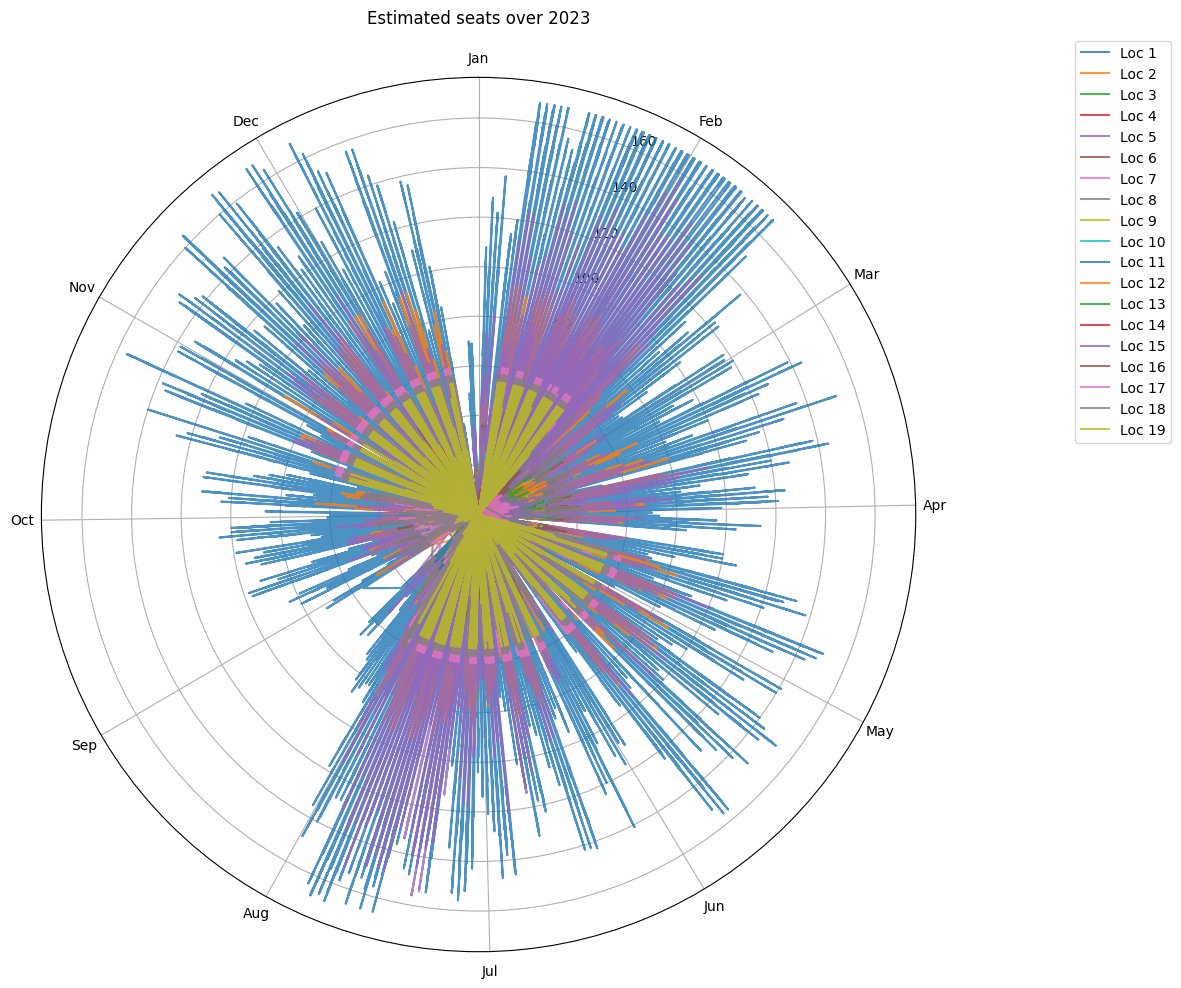

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

year = 2023

plot_data = merged[
    (merged["t10"].dt.year == year) &
    (merged["estimated_seats"].notna())
].copy()

# angle calculation
start = pd.Timestamp(f"{year}-01-01")
end = pd.Timestamp(f"{year+1}-01-01")
year_seconds = (end - start).total_seconds()

plot_data["angle"] = (
    (plot_data["t10"] - start).dt.total_seconds()
    / year_seconds
    * 2 * np.pi
)

# ---- figure (bigger) ----
fig, ax = plt.subplots(
    figsize=(12, 12),  # 👈 bigger plot
    subplot_kw={"polar": True}
)

# plot per location
for loc_id, g in plot_data.groupby("location_id"):
    ax.plot(g["angle"], g["estimated_seats"], alpha=0.8, label=f"Loc {loc_id}")

# ---- month ticks ----
months = pd.date_range(start, end, freq="MS")[:-1]
month_angles = (
    (months - start).total_seconds()
    / year_seconds
    * 2 * np.pi
)

ax.set_xticks(month_angles)
ax.set_xticklabels(months.strftime("%b"))  # Jan, Feb, …

# orientation
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.set_title(f"Estimated seats over {year}", pad=20)
ax.legend(bbox_to_anchor=(1.3, 1.05))

plt.tight_layout()
plt.show()



### Adding Building_id and valley-hill help column for grouping by locations


Each `location_id` is assigned to a `building_id`.  
Locations belonging to the same building share the same `building_id`.

#### Mapping buildings

- **Building 1: Ammerbau**: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14  
- **Building 2: Waschhalle**: 15, 16  
- **Building 3: PCB**: 18, 19  
- **Building 4: Bonatzbau**: 2, 3  
- **Building 5: Bereichsbibliothek**: 17  
- **Building 6: Lernzentrum Tal**: 1  
- **Building 7: Lernzentrum Morgenstelle**: 20  

#### Mapping Hill or Valley

Each `location_id` is assigned to  `is_hill` or not.  
Locations with flag `1` are located on a hill and all locations with `0` are in the valley.

- Buldings on the hill: 3, 5, 7

In [21]:
# mapping buildings
building_map = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 
    9: 1, 10: 1, 11: 1, 12: 1, 13: 1,
    14: 1, 15: 2, 16: 2, 18: 3, 19: 3,
    3: 4, 2: 4, 17: 5, 1: 6, 20: 7
}

# create new building_id column 
merged["building_id"] = merged["location_id"].map(building_map)
merged.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id
0,2016-04-12 13:00:00,1,NaN,NaN,NaN,NaN,50,"Lernzentrum, Hauptgebäude, 1. OG",168,08:00:00,00:00:00,6
1,2016-04-12 13:00:00,2,NaN,NaN,NaN,NaN,41,"Bonatzbau, EG",94,08:00:00,20:00:00,4
2,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4
3,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1
4,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1


In [22]:
# create flag for hill or valley location 
hill_buildings = {3, 5, 7}
merged["is_hill"] = merged["building_id"].isin(hill_buildings).astype(int)
merged.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill
0,2016-04-12 13:00:00,1,NaN,NaN,NaN,NaN,50,"Lernzentrum, Hauptgebäude, 1. OG",168,08:00:00,00:00:00,6,0
1,2016-04-12 13:00:00,2,NaN,NaN,NaN,NaN,41,"Bonatzbau, EG",94,08:00:00,20:00:00,4,0
2,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0
3,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0
4,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0


### remove covid years 
* first, we decide based on the data what covid period is relevant to use 
* second, we remove the data from out main data set and save the data to a seperate data set for specific covid analysis 

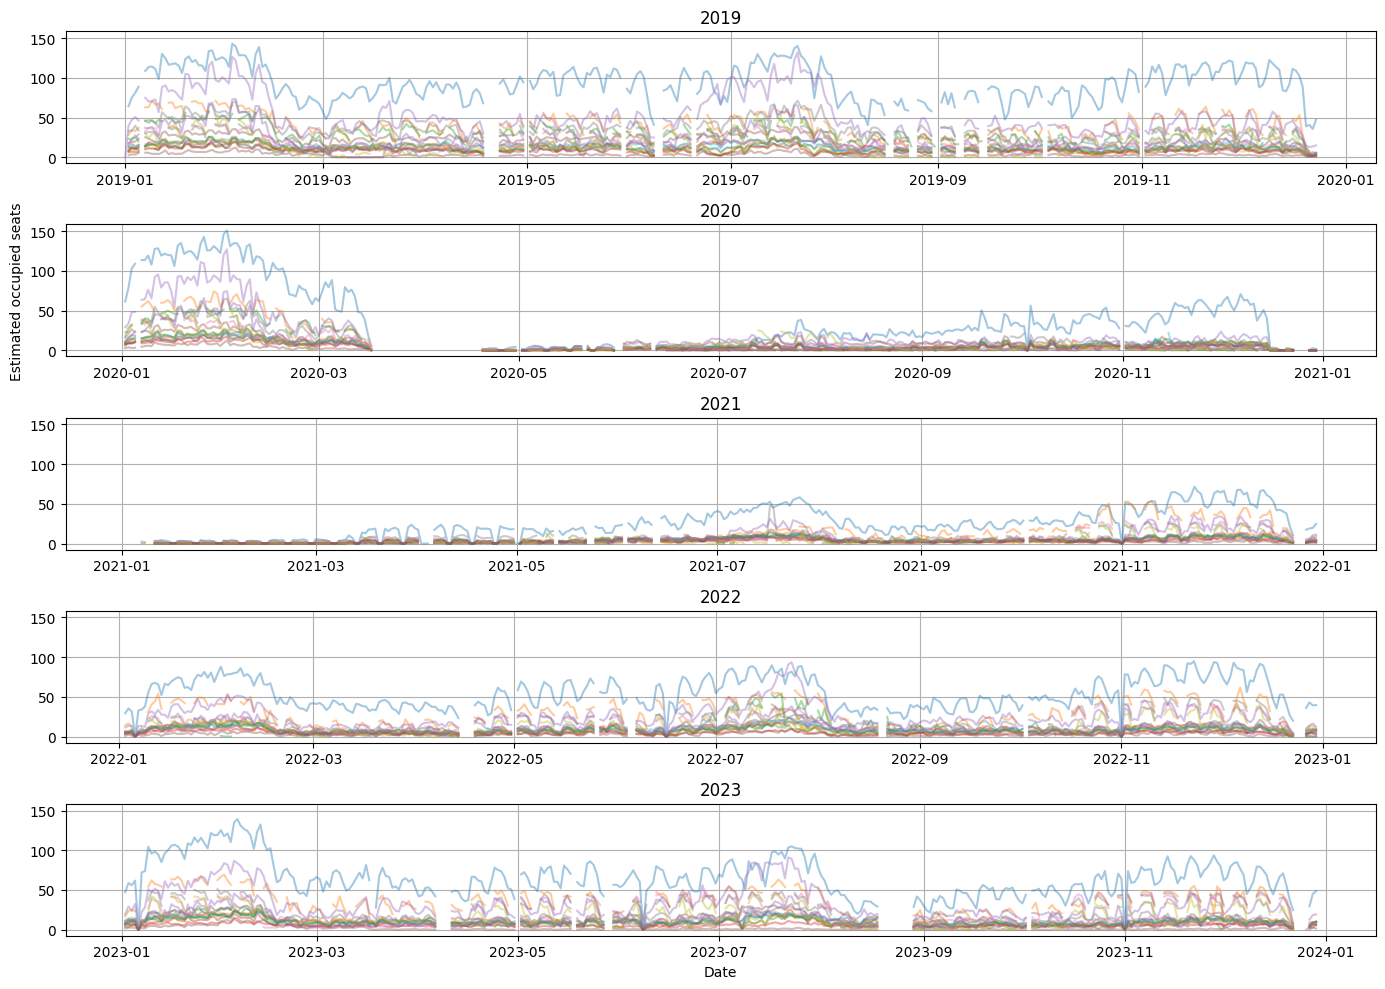

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

plot_covid_data = merged[
    (merged["t10"].dt.year.between(2019, 2023)) &           # define roughly the relevant time period 
    (merged["estimated_seats"].notna())
].copy()

# daily mean isi enough to show wether the library was open and an idea of the capacity 
daily = (
    plot_covid_data
    .set_index("t10")
    .groupby("location_id")
    .resample("D")["estimated_seats"]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharey=True)

for ax, year in zip(axes, [2019, 2020, 2021, 2022, 2023]):
    ydata = daily[daily["t10"].dt.year == year]
    
    for loc_id, g in ydata.groupby("location_id"):
        ax.plot(g["t10"], g["estimated_seats"], alpha=0.4)

    ax.set_title(str(year))
    ax.grid(True)

axes[-1].set_xlabel("Date")
axes[1].set_ylabel("Estimated occupied seats")

plt.tight_layout()
plt.show()



#### check for capacity boundary - did the capacity change over the covid years ? 

In [24]:
# compare capacity to check if there are any changes during the covid years 
daily_capacity = (
    plot_data
    .set_index("t10")
    .groupby("location_id")
    .resample("D")
    .agg({
        "estimated_seats": "first",
        "freeseats": "first",
        "availableseats": "first"   # capacity is static per location
    })
    .reset_index()
)
daily_capacity.head()


,location_id,t10,estimated_seats,freeseats,availableseats
0,1,2023-01-02,4.0,164.0,168.0
1,1,2023-01-03,4.0,164.0,168.0
2,1,2023-01-04,2.0,166.0,168.0
3,1,2023-01-05,4.0,164.0,168.0
4,1,2023-01-06,0.0,168.0,168.0


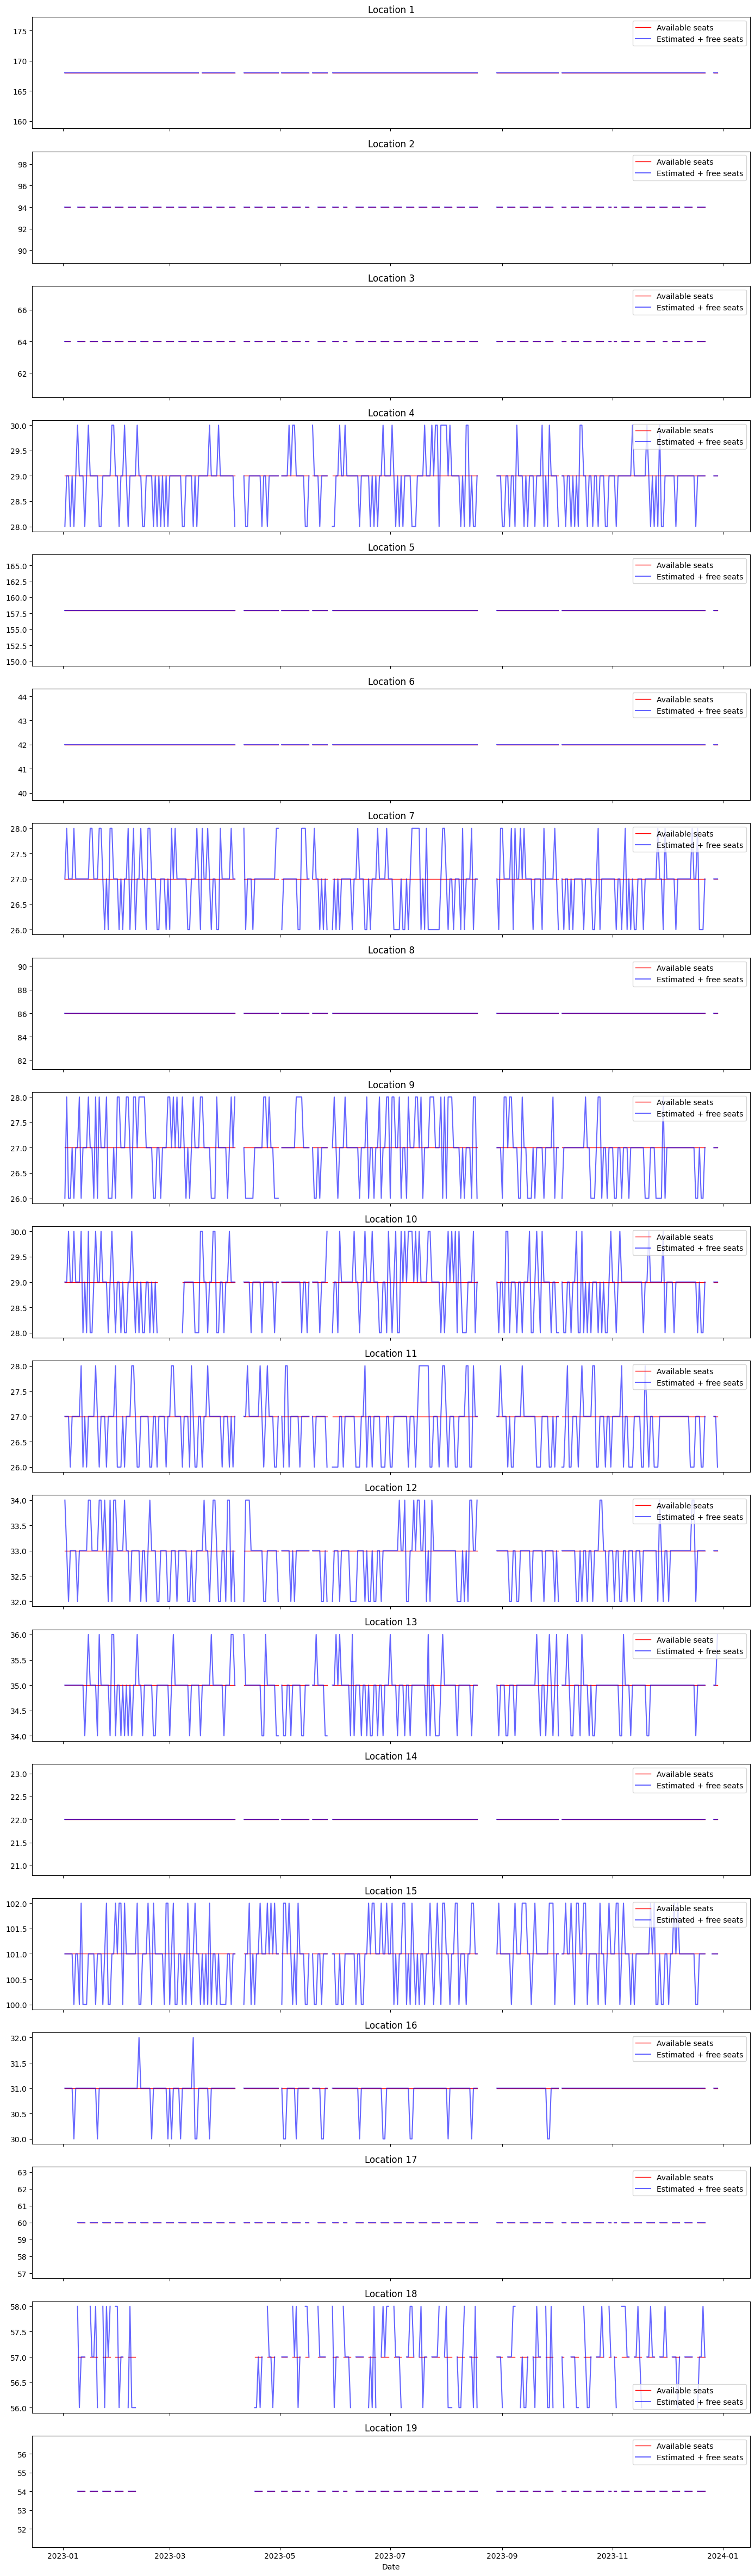

In [25]:
import matplotlib.pyplot as plt

# number of locations
n_locs = daily_capacity["location_id"].nunique()

# create subplots
fig, axes = plt.subplots(
    nrows=n_locs,
    ncols=1,
    figsize=(14, 2.5 * n_locs),
    sharex=True
)

# make axes iterable if only one location
if n_locs == 1:
    axes = [axes]

# group data
groups = list(daily_capacity.groupby("location_id"))

# plot
for i, (loc_id, g) in enumerate(groups):
    axes[i].plot(
        g["t10"],
        g["availableseats"],
        color="red",
        linewidth=1,
        label="Available seats"
    )
    axes[i].plot(
        g["t10"],
        g["estimated_seats"] + g["freeseats"],
        color="blue",
        alpha=0.6,
        label="Estimated + free seats"
    )
    axes[i].set_title(f"Location {loc_id}")
    axes[i].legend()

# labels
axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()


* estimation + freeseats almost matches the available seats number 
-> this shows that they did not change the capacity manually during the covid years (but I assume there where less spots because of distance rules)
* when it does not exactly match it is because of the 10 minutes increments and the rounding to integer (before rounding the data matched exactly)

#### some investigation to determine the covid period
* https://www.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/corona-schutzmassnahmen-des-bundes-enden-zum-8-april-2023
* 08.04.2023: all restrictions have been lifted 
* https://www.kreis-tuebingen.de/site/LRA-Tuebingen-Internet-2022/get/documents_E1829249897/lra_tuebingen/Objekte_Internet/03_Gesundheit_Lebensmittel/03%20Gesundheitsplanung,%20Gesundheitskonferenz/Corona%20Factsheet_%20202206.pdf
* 03.04.2022: most restrictions have been lifted 
* Here it makes more sense to use the 03.04.2022 as a final date of the covid periode (because there the last restrictions for librarys have been lifted)



#### Investigating start of covid Restriciton by plotting march of 2020

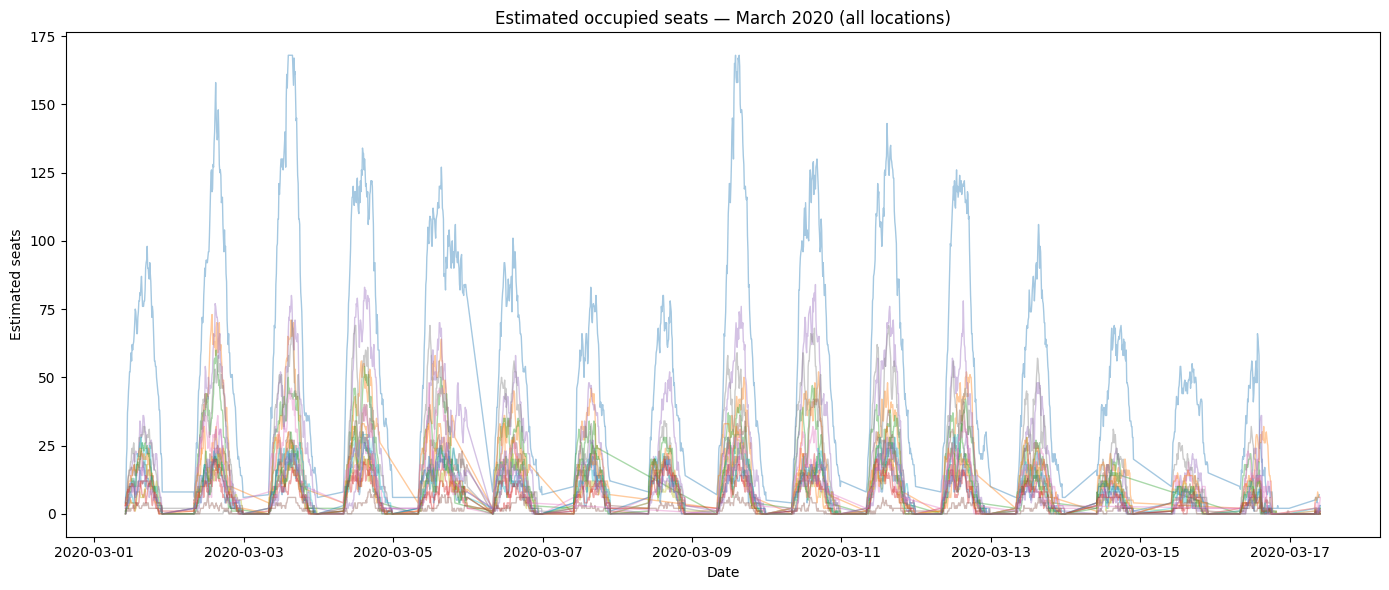

In [26]:
import matplotlib.pyplot as plt

# filter March 2020
march_2020 = merged[
    (merged["t10"] >= "2020-03-01") &
    (merged["t10"] <  "2020-04-01") &
    (merged["estimated_seats"].notna())
]

plt.figure(figsize=(14, 6))

for loc_id, g in march_2020.groupby("location_id"):
    plt.plot(
        g["t10"],
        g["estimated_seats"],
        alpha=0.4,
        linewidth=1,
        label=f"Loc {loc_id}"
    )

plt.title("Estimated occupied seats — March 2020 (all locations)")
plt.xlabel("Date")
plt.ylabel("Estimated seats")
plt.tight_layout()
plt.show()


* it seems like the librarys closed on 17.03.2020 
* it follows that the covid periods holds from 17.03.2020 to 03.04.2022
* create a data set with covid data and delete it from the main data set 

In [27]:
start = "2020-03-17"
end   = "2022-04-02" # 2022-04-03 is the frist day without the restricitons

covid_mask = merged["t10"].between(start, end)
# create a copy of the covid data 
merged_covid = merged[covid_mask].copy()        

# create a copy of the not covid data
merged_no_covid = merged[~covid_mask].copy()

# sanity check 
merged.shape
merged_covid.shape
merged_no_covid.shape

merged.shape[0] == merged_covid.shape[0] + merged_no_covid.shape[0]



True

### Save data sets

In [28]:
merged_covid.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill
2623747,2020-03-17 00:00:00,20,NaN,NaN,NaN,NaN,0,Lernzentrum Naturwissenschaften,101,00:00:00,00:00:00,7,1
2623748,2020-03-17 00:10:00,20,NaN,NaN,NaN,NaN,0,Lernzentrum Naturwissenschaften,101,00:00:00,00:00:00,7,1
2623749,2020-03-17 00:20:00,20,NaN,NaN,NaN,NaN,0,Lernzentrum Naturwissenschaften,101,00:00:00,00:00:00,7,1
2623750,2020-03-17 00:30:00,20,NaN,NaN,NaN,NaN,0,Lernzentrum Naturwissenschaften,101,00:00:00,00:00:00,7,1
2623751,2020-03-17 00:40:00,20,NaN,NaN,NaN,NaN,0,Lernzentrum Naturwissenschaften,101,00:00:00,00:00:00,7,1


In [29]:
merged_no_covid.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill
0,2016-04-12 13:00:00,1,NaN,NaN,NaN,NaN,50,"Lernzentrum, Hauptgebäude, 1. OG",168,08:00:00,00:00:00,6,0
1,2016-04-12 13:00:00,2,NaN,NaN,NaN,NaN,41,"Bonatzbau, EG",94,08:00:00,20:00:00,4,0
2,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0
3,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0
4,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0


### Deleting Locations that are not relevant to us 
- 1, 2: Lernzentrum UB and Bonatzbau, because these aren't quiet places 
- 8: Only useable for doctoral students 
- 20: Lernzentrum Morgenstelle: not accessible anymore 

In [30]:
locations_to_remove = [1, 2, 8, 20] 

merged_no_covid_clean = (
    merged_no_covid[
        ~merged_no_covid["location_id"].isin(locations_to_remove)
    ]
    .copy()
)

# sanity check 
assert not set(locations_to_remove) & set(merged_no_covid_clean["location_id"].unique())

### adding the column with unit of interest: relative availability 
* new column with relative availability = freeseats / (freeseats + occupiedseats)
* calculation based on seat estimates 

In [31]:
# calculate capacity from estimated seats and freeseats 
total = merged_no_covid_clean["freeseats"] + merged_no_covid_clean["estimated_seats"]

# calculate relative availability and add it as a new column to the data frame 
merged_no_covid_clean["relative_availability"] = np.where(total > 0, merged_no_covid_clean["freeseats"] / total, np.nan)


In [32]:
merged_no_covid_clean.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability
2,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0,NaN
3,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0,NaN
4,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0,NaN
5,2016-04-12 13:00:00,6,NaN,NaN,NaN,NaN,21,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,NaN
6,2016-04-12 13:00:00,7,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,NaN


In [ ]:
# saving data sets
try:
    merged_no_covid.to_csv("data/merged_no_covid.csv", index=False)
    print("main data saved ")
except Exception:
    print("Save failed")

try:
    merged_covid.to_csv("data/merged_covid.csv", index=False)
    print("covid data saved ")
except Exception:
    print("Save failed")

# save data with removed locations and unit of interest
try:
    merged_no_covid_clean.to_csv("data/final_data.csv", index=False)
    print("final data saved ")
except Exception:
    print("Save failed")

main data saved 
covid data saved 
final data saved 
